In [1]:
import requests
import pandas as pd

def get_openmeteo_data(lat, lon, start_date, end_date):
    """
    Get historical weather from Open-Meteo
    Free, no API key needed
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': start_date,
        'end_date': end_date,
        'daily': [
            'temperature_2m_max',
            'temperature_2m_min',
            'temperature_2m_mean',
            'precipitation_sum',
            'rain_sum',
            'precipitation_hours'
        ],
        'timezone': 'Africa/Nairobi'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame({
        'date': data['daily']['time'],
        'temp_max': data['daily']['temperature_2m_max'],
        'temp_min': data['daily']['temperature_2m_min'],
        'temp_mean': data['daily']['temperature_2m_mean'],
        'precipitation': data['daily']['precipitation_sum'],
        'rain': data['daily']['rain_sum'],
        'precip_hours': data['daily']['precipitation_hours']
    })
    
    df['date'] = pd.to_datetime(df['date'])
    return df

# Get data for Nairobi
nairobi_data = get_openmeteo_data(
    lat=-1.286389,
    lon=36.817223,
    start_date='2023-01-01',
    end_date='2023-01-31'
)

In [2]:
nairobi_data.head(5)

,date,temp_max,temp_min,temp_mean,precipitation,rain,precip_hours
0,2023-01-01,24.3,12.4,18.1,0.0,0.0,0.0
1,2023-01-02,23.1,11.8,16.7,1.1,1.1,7.0
2,2023-01-03,21.8,13.7,16.4,4.7,4.7,15.0
3,2023-01-04,21.7,14.1,16.9,2.1,2.1,11.0
4,2023-01-05,23.8,13.2,17.5,0.5,0.5,4.0


In [3]:
# Using NASA POWER API
import requests
import pandas as pd
from datetime import datetime

def get_nasa_power_data(lat, lon, start_date, end_date, parameters):
    """
    Get historical weather data from NASA POWER
    
    Parameters for agriculture:
    - T2M: Temperature at 2 Meters (°C)
    - PRECTOTCORR: Precipitation (mm/day)
    - RH2M: Relative Humidity at 2 Meters (%)
    - WS2M: Wind Speed at 2 Meters (m/s)
    """
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    params = {
        'parameters': ','.join(parameters),
        'community': 'AG',  # Agricultural community
        'longitude': lon,
        'latitude': lat,
        'start': start_date,
        'end': end_date,
        'format': 'JSON'
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Convert to DataFrame
    df = pd.DataFrame(data['properties']['parameter'])
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    
    return df

# Example: Get data for Nairobi, Kenya
nairobi_weather = get_nasa_power_data(
    lat=-1.286389,
    lon=36.817223,
    start_date='20230101',
    end_date='20231231',
    #parameters=['T2M', 'PRECTOTCORR', 'RH2M', 'WS2M']
    parameters = [
    'T2M', 'T2M_MAX', 'T2M_MIN',       # Temperature extremes
    'PRECTOTCORR',                      # Rainfall
    'RH2M',                             # Humidity (affects pests/diseases)
    'WS2M',                             # Wind
    'ALLSKY_SFC_SW_DWN',               # Solar radiation
    'FROST_DAYS'                        # Frost events
]
)

nairobi_weather.head()

,T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,RH2M,WS2M,ALLSKY_SFC_SW_DWN,FROST_DAYS
2023-01-01,20.40,28.13,14.23,0.15,57.80,4.24,26.25,0.0
2023-01-02,19.70,26.63,13.87,0.90,66.31,4.68,21.82,0.0
2023-01-03,18.91,25.31,14.49,3.45,74.46,4.68,19.53,0.0
2023-01-04,18.75,25.87,13.75,2.58,75.80,4.45,16.42,0.0
2023-01-05,19.56,27.11,14.89,0.58,68.53,4.12,24.29,0.0


In [4]:
import duckdb
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import HTML, display
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

import spacy
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import subprocess

# Download required NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1 - Initial exploration using a data sample. Ramdom selection of 100,000 row.

In [5]:
# Quick exploration
conn = duckdb.connect()

print("=" * 60)
print("STEP 1: Checking CSV Structure")
print("=" * 60)

columns_info = conn.execute("""
    DESCRIBE SELECT * FROM 'b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv' LIMIT 1
""").df()
print(f"\nTotal columns: {len(columns_info)}")
print("\nColumn Information:")
columns_info

STEP 1: Checking CSV Structure

Total columns: 24

Column Information:


,column_name,column_type,null,key,default,extra
0,question_id,BIGINT,YES,None,None,None
1,question_user_id,BIGINT,YES,None,None,None
2,question_language,VARCHAR,YES,None,None,None
3,question_content,VARCHAR,YES,None,None,None
4,question_topic,VARCHAR,YES,None,None,None
5,question_sent,TIMESTAMP WITH TIME ZONE,YES,None,None,None
6,response_id,BIGINT,YES,None,None,None
7,response_user_id,BIGINT,YES,None,None,None
8,response_language,VARCHAR,YES,None,None,None
9,response_content,VARCHAR,YES,None,None,None


In [6]:
# Get a quick peek at first few rows
#pd.set_option('display.max_columns', None)
print("\n" + "=" * 60)
print("STEP 2: Preview First 5 Rows")
print("=" * 60)

# First, get column names and types
sample = conn.execute("""
    SELECT * FROM 'b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv'
                      USING SAMPLE 100000 ROWS;
""").df()

print(f"Sample rows: {len(sample)}, Columns: {len(sample.columns)}")

sample.head(5)
 

#preview_df = preview if isinstance(preview, pd.DataFrame) else pd.DataFrame(preview)



STEP 2: Preview First 5 Rows
Sample rows: 100000, Columns: 24


,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,response_topic,response_sent,question_user_type,question_user_status,question_user_country_code,question_user_gender,question_user_dob,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at
0,8956685,539129,eng,Q. Last year i used Ransom to prevent powdery ...,None,2018-08-17 11:09:47.591874+01:00,8962759,115844,eng,"Q176.paul,hello.Try Rindomil gold.if it persis...",None,2018-08-17 12:35:20.103876+01:00,farmer,live,ke,None,NaT,2017-11-27 06:37:56+00:00,farmer,live,ke,male,1983-06-18,2016-10-27 06:24:16+01:00
1,45894678,3202239,swa,S Kwakawaida kuku huwa anaatamia siku ngapi nd...,poultry,2020-08-14 10:31:47.937520+01:00,45894704,3057760,swa,S41 Cku 21,None,2020-08-14 10:32:49.735702+01:00,farmer,live,tz,None,NaT,2020-07-01 15:51:11.785200+01:00,farmer,live,tz,None,NaT,2020-04-21 15:33:34.574062+01:00
2,20554941,1307830,nyn,E Canter ya watermelon negura eta okwo?,watermelon,2019-01-20 16:45:00.640571+00:00,20560605,980656,nyn,E31 \n3 000 mijina Rwemikoma,None,2019-01-20 22:10:12.311304+00:00,farmer,live,ug,None,1978-02-06,2018-10-07 16:53:23.425676+01:00,farmer,zombie,ug,None,NaT,2018-07-11 19:21:22.441478+01:00
3,41466828,2597297,eng,Q Am Denis From Kaliro What Requrement If I Ne...,pig,2020-05-02 19:46:01.502960+01:00,41467228,931981,eng,"Q202.YOU HAVE TO GET ,MUKENE MAIZEGRADE,",None,2020-05-02 19:50:58.339493+01:00,farmer,live,ug,None,NaT,2019-10-21 13:08:33.683476+01:00,farmer,live,ug,None,NaT,2018-06-22 18:18:50.828802+01:00
4,51888144,3518986,eng,What is the name of the good food for the ...,chicken,2020-12-27 05:10:16.805963+00:00,51894398,2174189,eng,Q 111 Chick mash.,chicken,2020-12-27 06:33:35.626280+00:00,farmer,live,ke,None,NaT,2020-12-24 17:47:31.427722+00:00,farmer,live,ke,None,NaT,2019-05-29 20:57:10.251209+01:00


## Completeness check using missingno


<Figure size 1200x600 with 0 Axes>

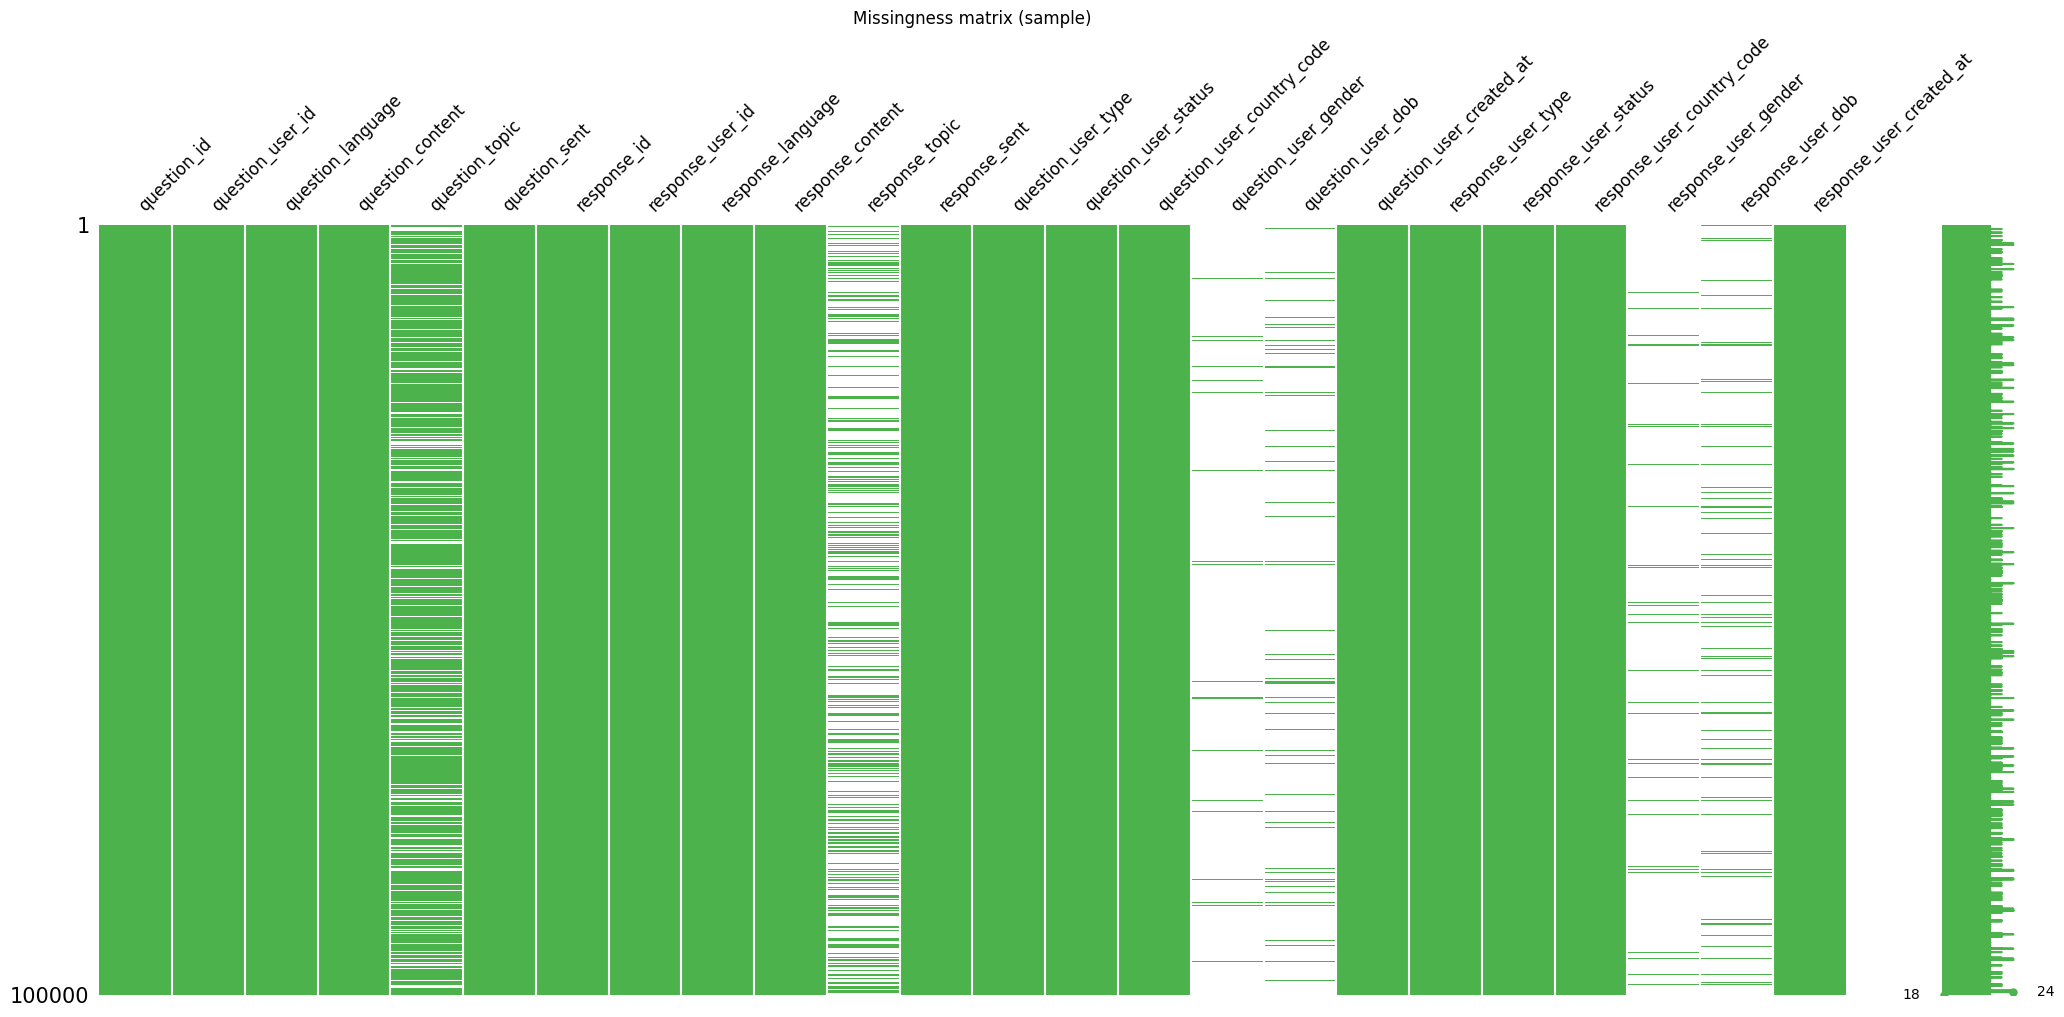

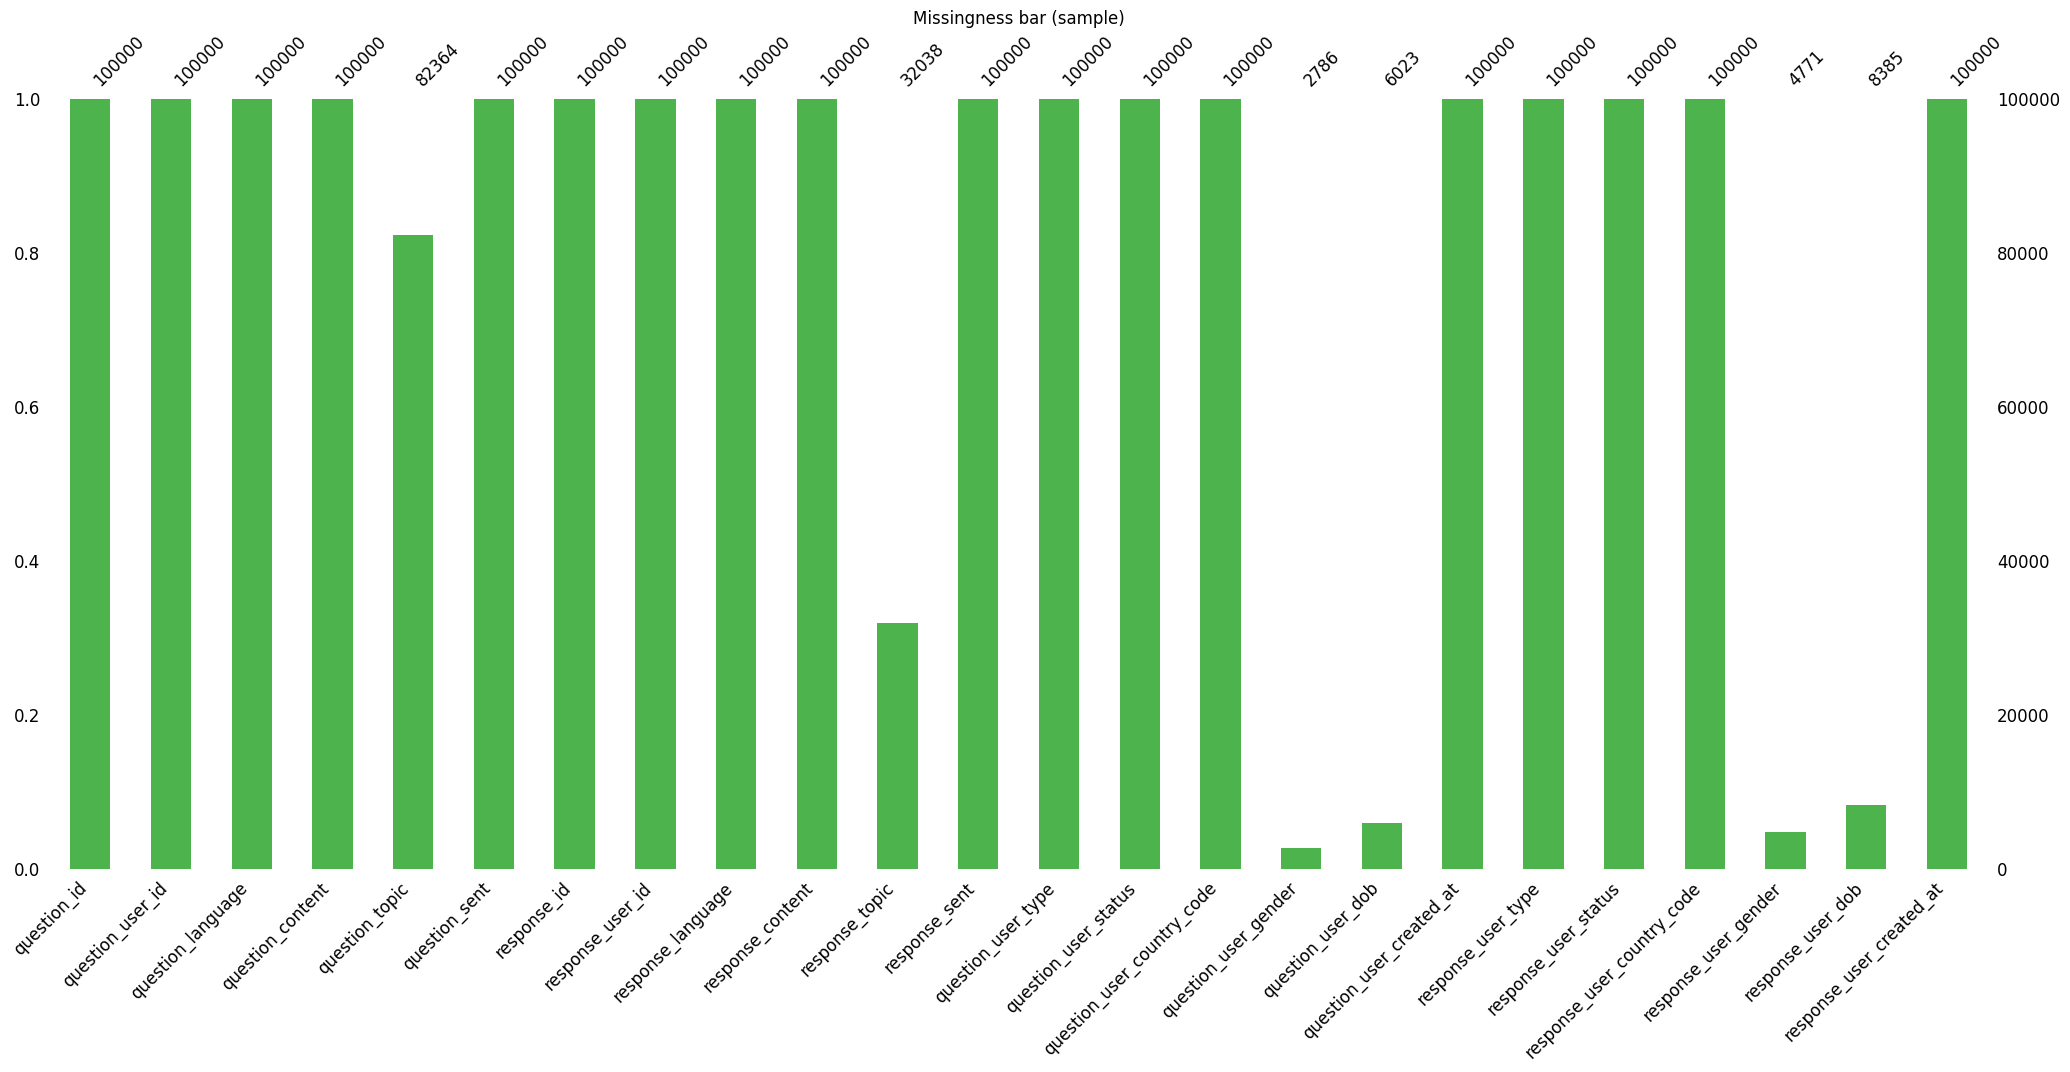

In [7]:
# missingno matrix: shows a visual sparsity grid (white = missing)
plt.figure(figsize=(12, 6))
msno.matrix(sample, fontsize=12, color=(0.3, 0.7, 0.3))
plt.title("Missingness matrix (sample)")
plt.show()

# missingno bar: shows percent present/missing per column
plt.figure(figsize=(10, 6))
msno.bar(sample, fontsize=12, color=(0.3, 0.7, 0.3))
plt.title("Missingness bar (sample)")
plt.show()

In [8]:
# Unique value counts for key columns
key_columns = ['question_user_id', 'question_language', 'question_content', 'question_topic', 'response_language', 
       'response_topic', 'question_user_type', 'question_user_gender',
       'question_user_country_code','response_user_type', 'response_user_status',
       'response_user_country_code', 'response_user_gender'] 
print("\nUnique value counts for key columns:")
for col in key_columns:
    unique_count = sample[col].nunique(dropna=True)
    print(f"  {col}: {unique_count}")


Unique value counts for key columns:
  question_user_id: 76846
  question_language: 4
  question_content: 97150
  question_topic: 139
  response_language: 4
  response_topic: 138
  question_user_type: 1
  question_user_gender: 2
  question_user_country_code: 4
  response_user_type: 1
  response_user_status: 4
  response_user_country_code: 4
  response_user_gender: 2


In [9]:
def safe_plotly_show(fig):
    try:
        fig.show()
    except Exception:
        display(HTML(pio.to_html(fig, include_plotlyjs='cdn')))

# Plot unique value counts for key categorical columns using Plotly:
# - if unique values <= 4 -> pie chart
# - otherwise -> bar chart (top 20)
for col in key_columns:
    if col not in sample.columns:
        print(f"Column not found: {col}")
        continue
    try:
        uniq_count = sample[col].nunique(dropna=True)
        if uniq_count == 0:
            print(f"No values for column: {col}")
            continue

        if uniq_count <= 4:
            vc = sample[col].value_counts(dropna=False)  # include NaNs in pie
            fig = px.pie(values=vc.values, names=vc.index.astype(str),
                         title=f"Distribution of '{col}' (pie, {uniq_count} unique)")
            #fig.update_traces(textposition='inside', textinfo='percent+label+value')
            fig.update_traces(textposition='inside', textinfo='value+label')
        else:
            vc = sample[col].value_counts().head(20)
            fig = px.bar(x=vc.index.astype(str), y=vc.values,
                         title=f"Top 20 Unique Values in '{col}' (bar)")
            fig.update_layout(xaxis_title=col, yaxis_title='Count', bargap=0.2)
            fig.update_traces(text=vc.values, textposition='outside')

        safe_plotly_show(fig)
    except Exception as e:
        print(f"Failed plotting {col}: {e}")

### Plot distribution of questions by month

In [10]:
# ============================================================
# Plot distribution of questions by month
# ============================================================
print("\n" + "=" * 60)
print("STEP: Questions Distribution by Month")
print("=" * 60)

# Check for date/timestamp columns
date_cols = [col for col in sample.columns if any(keyword in col.lower() for keyword in ['date', 'time', 'created', 'posted', 'timestamp'])]
print(f"\nDate/Time columns found: {date_cols}")
print(sample[date_cols].head() if date_cols else "No date columns found")

# If you have a date column, convert and extract month
# Adjust column name based on your actual data
if date_cols:
    date_col = date_cols[0]  # Use first date column
    sample['question_date'] = pd.to_datetime(sample[date_col], errors='coerce')
    sample['question_month'] = sample['question_date'].dt.to_period('M')
    
    # Count questions by month
    questions_by_month = sample['question_month'].value_counts().sort_index()
    
    # Plot
    fig = px.bar(
        x=questions_by_month.index.astype(str),
        y=questions_by_month.values,
        title='Number of Questions Asked by Month',
        labels={'x': 'Month', 'y': 'Number of Questions'},
        text=questions_by_month.values
    )
    fig.update_traces(textposition='outside')
    fig.update_layout(height=600, width=1200, xaxis_tickangle=-45)
    safe_plotly_show(fig)
    
    print(f"\nTotal questions by month:")
    print(questions_by_month)
else:
    print("\nNo date column found in dataset. Available columns:")
    print(sample.columns.tolist())


STEP: Questions Distribution by Month

Date/Time columns found: ['question_user_created_at', 'response_user_created_at']
          question_user_created_at         response_user_created_at
0        2017-11-27 06:37:56+00:00        2016-10-27 06:24:16+01:00
1 2020-07-01 15:51:11.785200+01:00 2020-04-21 15:33:34.574062+01:00
2 2018-10-07 16:53:23.425676+01:00 2018-07-11 19:21:22.441478+01:00
3 2019-10-21 13:08:33.683476+01:00 2018-06-22 18:18:50.828802+01:00
4 2020-12-24 17:47:31.427722+00:00 2019-05-29 20:57:10.251209+01:00


C:\Users\DELL\AppData\Local\Temp\ipykernel_222252\3254173664.py:18: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.




Total questions by month:
question_month
2014-11     3
2015-02     8
2015-03     3
2015-04    14
2015-05     2
           ..
2021-10     4
2021-12     2
2022-01     8
2022-02     3
2022-03     5
Freq: M, Name: count, Length: 86, dtype: int64


In [11]:
# ============================================================
# Plot distribution of asked questions languages by country
# ============================================================
print("\n" + "=" * 60)
print("STEP: Distribution of Question Languages by Country")
print("=" * 60)

# Get unique countries
countries = sample['question_user_country_code'].dropna().unique()

for country in sorted(countries):
    country_sample = sample[sample['question_user_country_code'] == country]
    
    if len(country_sample) == 0:
        continue
    
    # Get language distribution for this country
    lang_counts = country_sample['question_language'].value_counts(dropna=False)
    uniq_lang_count = country_sample['question_language'].nunique(dropna=True)
    
    try:
        if uniq_lang_count <= 4:
            # Pie chart for few languages
            fig = px.pie(values=lang_counts.values, names=lang_counts.index.astype(str),
                         title=f"Question Languages Distribution in '{country}' ({len(country_sample)} records, {uniq_lang_count} unique)")
            fig.update_traces(textposition='inside', textinfo='value+label+percent')
        else:
            # Bar chart for many languages
            fig = px.bar(x=lang_counts.index.astype(str), y=lang_counts.values,
                         title=f"Question Languages Distribution in '{country}' ({len(country_sample)} records)")
            fig.update_layout(xaxis_title='Language', yaxis_title='Count', bargap=0.2)
            fig.update_traces(text=lang_counts.values, textposition='outside')
        
        safe_plotly_show(fig)
    except Exception as e:
        print(f"Failed plotting language distribution for {country}: {e}")



STEP: Distribution of Question Languages by Country


In [12]:
# Create a summary dataframe for all countries
lang_by_country = []

for country in sorted(sample['question_user_country_code'].dropna().unique()):
    country_sample = sample[sample['question_user_country_code'] == country]
    lang_counts = country_sample['question_language'].value_counts()
    
    for lang, count in lang_counts.items():
        lang_by_country.append({'Country': country, 'Language': lang, 'Count': count})

lang_country_df = pd.DataFrame(lang_by_country)


In [13]:
# Create stacked bar chart (easier to see total per country)
fig = px.bar(lang_country_df, x='Country', y='Count', color='Language',
             title='Question Languages Distribution by Country (Stacked)',
             barmode='stack')
fig.update_layout(height=500, width=1200)
safe_plotly_show(fig)

In [14]:
country_list = list(lang_country_df['Country'].unique())
language_list = list(lang_country_df['Language'].unique())
labels = country_list + language_list

country_to_index = {country: i for i, country in enumerate(country_list)}
language_to_index = {lang: i + len(country_list) for i, lang in enumerate(language_list)}

sources = lang_country_df['Country'].map(country_to_index)
targets = lang_country_df['Language'].map(language_to_index)
values = lang_country_df['Count']

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title='Language Flow from Country (Sankey Diagram)',
    height=700,
    width=1200,
    font_size=10
)

safe_plotly_show(fig)

## Note on language filtering impact

- By restricting the analysis to English-language questions, we risk excluding users from countries where other languages are prevalent. For example, many users in Tanzania primarily ask questions in Swahili.
- The visualizations show that several countries have significant activity in local languages.
- Excluding non-English questions may bias results, underrepresenting user needs and behaviors in those regions.

In [15]:
sample[sample['question_content'] == 'What is farming?']

,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,response_topic,response_sent,question_user_type,question_user_status,question_user_country_code,question_user_gender,question_user_dob,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at,question_date,question_month
3927,58025008,3333173,eng,What is farming?,None,2021-08-04 19:05:16.840967+01:00,58025272,2002530,eng,Is the growing of crops and raring of animals ...,animal,2021-08-04 19:09:21.627121+01:00,farmer,blocked,ug,None,NaT,2020-09-22 13:16:27.528061+01:00,farmer,live,ug,None,NaT,2019-04-02 15:18:34.253377+01:00,2020-09-22 13:16:27.528061+01:00,2020-09
8220,53857922,2596991,eng,What is farming?,None,2021-02-26 10:49:29.009526+00:00,53857998,3337753,eng,Q30 farming is the growing of crops & rearing ...,crop,2021-02-26 10:52:09.482165+00:00,farmer,live,ug,None,NaT,2019-10-21 11:37:40.055661+01:00,farmer,live,ug,None,NaT,2020-09-24 14:59:49.404085+01:00,2019-10-21 11:37:40.055661+01:00,2019-10
12960,55079162,3620250,eng,What is farming?,None,2021-04-05 17:43:37.164131+01:00,55084761,3103857,eng,Q192: is the rearing of animals and growing of...,crop,2021-04-05 19:31:05.715273+01:00,farmer,blocked,ug,None,NaT,2021-04-05 17:31:52.760872+01:00,farmer,live,ug,None,NaT,2020-05-08 17:43:38.748718+01:00,2021-04-05 17:31:52.760872+01:00,2021-04
13573,34359596,2622597,eng,What is farming?,None,2019-11-18 11:04:16.224275+00:00,34363237,2616522,eng,"what is farming ? , the growing of crops and r...",crop,2019-11-18 13:17:45.653503+00:00,farmer,live,ug,None,NaT,2019-10-27 17:51:03.034261+00:00,farmer,live,ug,None,NaT,2019-10-26 16:40:27.983962+01:00,2019-10-27 17:51:03.034261+00:00,2019-10
21598,49812413,2990005,eng,What is farming?,None,2020-11-16 18:40:43.897774+00:00,49816379,2358598,eng,q97 farming is the growing of crops and rearin...,animal,2020-11-16 20:14:02.457412+00:00,farmer,live,ug,None,NaT,2020-03-26 13:48:43.226509+00:00,farmer,live,ug,None,NaT,2019-08-07 18:53:17.411067+01:00,2020-03-26 13:48:43.226509+00:00,2020-03
33356,54828133,2929024,eng,What is farming?,None,2021-03-28 21:13:26.629922+01:00,54908275,1458938,eng,Q1586 the growing of crops and rearing animals,animal,2021-03-31 08:48:10.536641+01:00,farmer,live,ug,None,NaT,2020-02-29 18:23:35.470174+00:00,farmer,live,ug,None,NaT,2018-11-14 09:17:06.514038+00:00,2020-02-29 18:23:35.470174+00:00,2020-02
41470,49198763,3240693,eng,What is farming?,None,2020-11-06 10:55:00.765239+00:00,49198942,3237230,eng,Q51 Farming is the growing Crops and rearing o...,crop,2020-11-06 10:58:15.452675+00:00,farmer,live,ug,None,NaT,2020-07-22 16:02:14.497506+01:00,farmer,live,ug,None,NaT,2020-07-20 19:34:48.478354+01:00,2020-07-22 16:02:14.497506+01:00,2020-07
46535,49167363,3396257,eng,What is farming?,None,2020-11-05 19:15:41.820352+00:00,49172819,2376257,eng,Q85 farming is the science and art of growing ...,animal,2020-11-06 04:41:07.799832+00:00,farmer,live,ug,None,NaT,2020-10-25 18:40:30.391829+00:00,farmer,live,ug,None,NaT,2019-08-14 15:06:15.478475+01:00,2020-10-25 18:40:30.391829+00:00,2020-10
56197,54552974,3570383,eng,What is farming?,None,2021-03-20 15:46:34.634326+00:00,54553961,1020468,eng,Q298 Its the growing ov crops and rearing ov a...,animal,2021-03-20 16:16:06.375082+00:00,farmer,live,ug,None,NaT,2021-02-17 16:46:20.591942+00:00,farmer,live,ug,None,NaT,2018-07-27 15:58:12.807293+01:00,2021-02-17 16:46:20.591942+00:00,2021-02
63440,40283582,510487,eng,What is farming?,None,2020-04-14 09:27:34.425647+01:00,40285511,2578914,eng,QII Farming is the cultivation of the field fo...,poultry,2020-04-14 10:15:20.383191+01:00,farmer,live,ug,None,2012-06-09,2017-11-15 09:45:25+00:00,farmer,live,ug,None,NaT,2019-10-14 12:44:56.085877+01:00,2017-11-15 09:45:25+00:00,2017-11


In [16]:
sample[sample['question_content'] == 'What is crop rotation?']

,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,response_topic,response_sent,question_user_type,question_user_status,question_user_country_code,question_user_gender,question_user_dob,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at,question_date,question_month
6680,36686239,2825409,eng,What is crop rotation?,crop,2020-01-21 12:34:45.406993+00:00,36738190,1146371,eng,"Q366.CHANGE FROM ONE TO ANOTHER IN A FARM.EG,F...",maize,2020-01-22 19:02:27.778608+00:00,farmer,live,ke,None,NaT,2020-01-21 12:32:27.362104+00:00,farmer,live,ke,None,NaT,2018-08-28 18:38:29.136641+01:00,2020-01-21 12:32:27.362104+00:00,2020-01
7393,31968698,1120075,eng,What is crop rotation?,crop,2019-09-21 13:36:01.168910+01:00,31969087,256399,eng,Q80 is da planting ov crops in da sem garden s...,crop,2019-09-21 13:48:54.577178+01:00,farmer,destroyed,ug,None,NaT,2018-08-23 16:08:51.957023+01:00,farmer,blocked,ug,None,NaT,2017-07-10 15:29:59+01:00,2018-08-23 16:08:51.957023+01:00,2018-08
13006,58194466,3568751,eng,What is crop rotation?,crop,2021-08-10 08:33:03.293821+01:00,58194773,1492916,eng,It is the growing of different crops at differ...,crop,2021-08-10 08:48:10.559716+01:00,farmer,live,ug,None,NaT,2021-02-15 06:38:13.188997+00:00,farmer,live,ug,None,NaT,2018-11-17 04:36:24.521959+00:00,2021-02-15 06:38:13.188997+00:00,2021-02
21147,40362014,491418,eng,What is crop rotation?,crop,2020-04-15 16:10:45.430036+01:00,40366297,1787020,eng,Q110 growing of different crops on the same pi...,crop,2020-04-15 17:23:51.699255+01:00,farmer,live,ug,None,NaT,2017-11-08 13:47:39+00:00,farmer,live,ug,None,NaT,2018-12-23 18:35:45.701799+00:00,2017-11-08 13:47:39+00:00,2017-11
21716,49091279,3225336,eng,What is crop rotation?,crop,2020-11-04 04:30:27.729010+00:00,49124600,3414600,eng,Q1 the heighest desire for sex in animal is ca...,animal,2020-11-04 19:25:05.933481+00:00,farmer,blocked,ug,None,NaT,2020-07-14 20:34:53.865307+01:00,farmer,live,ug,None,NaT,2020-11-03 20:19:34.779784+00:00,2020-07-14 20:34:53.865307+01:00,2020-07
27182,15957097,1179954,eng,What is crop rotation?,crop,2018-11-16 17:05:11.081254+00:00,15958842,430045,eng,Q50 it is the growing if different crops on th...,crop,2018-11-16 17:11:39.853520+00:00,farmer,zombie,ug,None,NaT,2018-09-08 16:29:38.743634+01:00,farmer,live,ug,None,NaT,2017-10-12 11:58:57+01:00,2018-09-08 16:29:38.743634+01:00,2018-09
34748,37745583,1130713,eng,What is crop rotation?,crop,2020-02-22 17:03:22.512756+00:00,37746205,2648922,eng,Q168. Is da growng ov crops seaso aftr season ...,crop,2020-02-22 17:14:14.163829+00:00,farmer,live,ug,None,NaT,2018-08-24 13:25:44.381994+01:00,farmer,live,ug,None,NaT,2019-11-08 11:35:26.563984+00:00,2018-08-24 13:25:44.381994+01:00,2018-08
48568,58877204,3489037,eng,What is crop rotation?,crop,2021-09-05 11:30:18.549788+01:00,58879749,3697893,eng,Q45 ask yr teacher mwana,None,2021-09-05 13:13:19.528558+01:00,farmer,live,ug,None,NaT,2020-12-03 17:41:34.423119+00:00,farmer,blocked,ug,None,NaT,2021-06-12 06:26:10.243129+01:00,2020-12-03 17:41:34.423119+00:00,2020-12
62953,16059673,138399,eng,What is crop rotation?,crop,2018-11-17 15:53:34.899934+00:00,16086540,824442,eng,growing of different annual crops season after...,crop,2018-11-17 20:05:52.975703+00:00,farmer,live,ug,None,NaT,2016-12-16 16:30:12+00:00,farmer,zombie,ug,None,NaT,2018-05-04 19:19:13.225909+01:00,2016-12-16 16:30:12+00:00,2016-12
66479,53254887,2010798,eng,What is crop rotation?,crop,2021-02-06 06:08:11.547034+00:00,53264549,1630723,eng,Crop rotation is the growing ov crops en reari...,crop,2021-02-06 13:07:26.955024+00:00,farmer,blocked,ug,None,NaT,2019-04-03 07:02:03.678211+01:00,farmer,live,ug,None,NaT,2018-12-07 09:02:03.153663+00:00,2019-04-03 07:02:03.678211+01:00,2019-04


In [17]:
sample[sample['question_content'] == 'What is crop rotation?']['response_content'].tolist()

['Q366.CHANGE FROM ONE TO ANOTHER IN A FARM.EG,FRM TOMATOE TO MAIZE TO WIMBI TO BEANS,ETC.',
 'Q80 is da planting ov crops in da sem garden season after season but ov da different types.',
 'It is the growing of different crops at different season or seasonally in the same garden',
 'Q110 growing of different crops on the same piece of land seasonally',
 'Q1 the heighest desire for sex in animal is called',
 'Q50 it is the growing if different crops on the same piece of land seasonally',
 'Q168. Is da growng ov crops seaso aftr season on da same piece ov land',
 'Q45 ask yr teacher mwana',
 'growing of different annual crops season after season',
 'Crop rotation is the growing ov crops en rearing ov animals',
 'Q101 Crop rotation is the growing of different crops on the same piece of land in different seasons.and it is good coz pests and diseses are controlled.',
 'Is the growing of different crops on the same piece of land season after season. For example, when u plant maize in the fi

### Exploration

In [18]:
print(f"Question: {sample.question_content[16]}\nAnswer: {sample.response_content[16]}")

Question: S Alex, Nunua Mtama Au Mwere Ama   Sunflawer Uwapee Kuku Wako Na Watakua Haraka,
Answer: S1029, asante salome inasaidia sana hasa kuku za kienyeji.


In [19]:
print(f"Question: {sample.question_content[117]}\nAnswer: {sample.response_content[117]}")

Question: Q Ni Mbolea Gan Unaeza Toptresing Suguma & Sucha
Answer: S164  can


In [20]:
print(f"Question: {sample.question_content[1155]}\nAnswer: {sample.response_content[1155]}")

Question: S nina ng'ombe wanasumbuliwa na kupe n2mie dawa .gan?
Answer: S56 ATUMIE DIPU KILA BAADA YA SIKU 7 AU SIKU 14


In [21]:
print(f"Question: {sample.question_content[1257]}\nAnswer: {sample.response_content[1257]}")

Question: Q.A farmer asks: how can someone hydropinic system to plant tomatoes and how can someone find the hydroponic materials Reply Q375 followed by your response.
Answer: Q68 VISIT AGRICURAL CENTER NEAR U


In [22]:
subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])

# Now load the model
nlp = spacy.load("en_core_web_sm")

my_stopwords = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def process_text(text):
    # Text Cleaning + lower case
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', str(text)).lower()
    
    # Tokenization
    doc = nlp(cleaned_text)
    
    # Lemmatization and stopword removal
    processed_tokens = [token.lemma_.lower() for token in doc if (token.lemma_.lower() not in my_stopwords) and (len(token.lemma_.lower()) > 2)]

    # Join processed tokens and normalize spaces
    joined_tokens = re.sub(r'\s{2,}', ' ', ' '.join(processed_tokens))
    
    return joined_tokens


C:\Users\DELL\AppData\Local\Temp\ipykernel_222252\1033669385.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



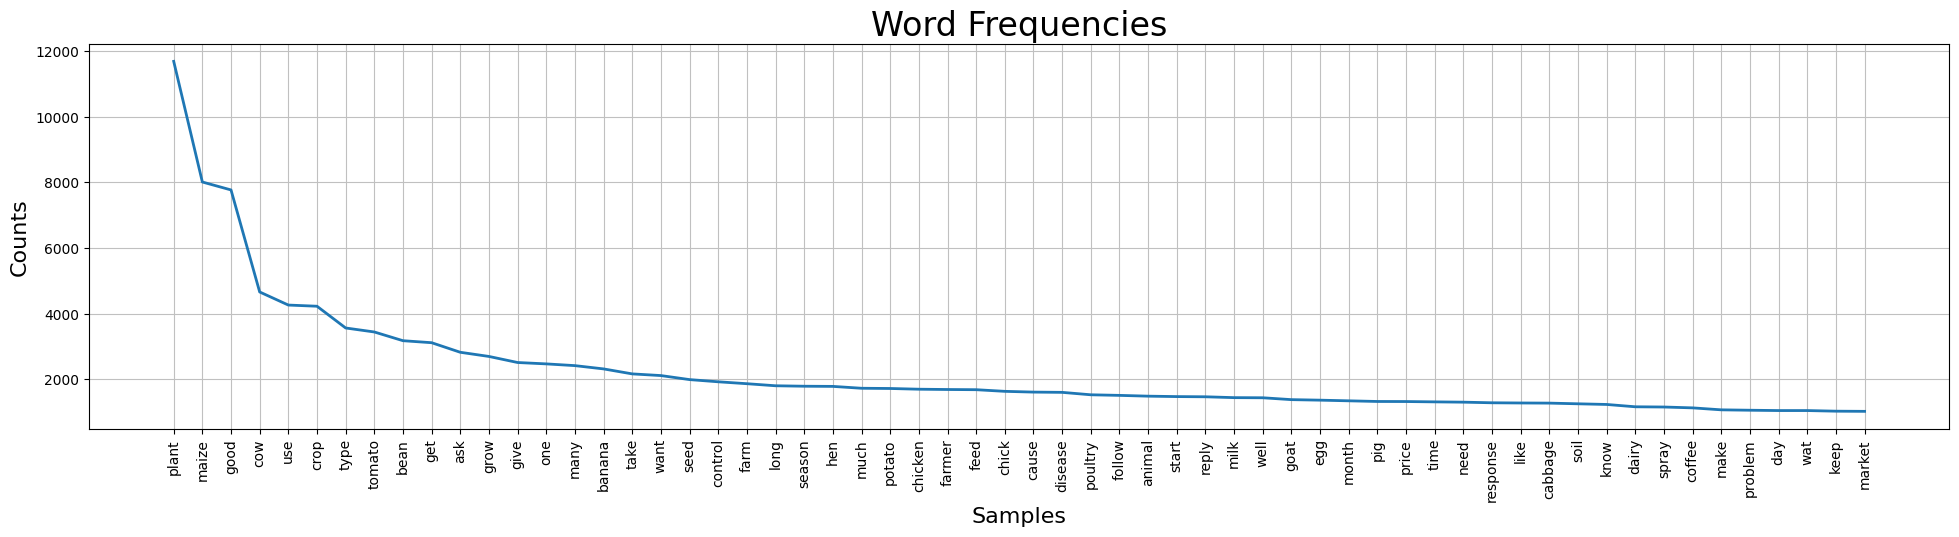

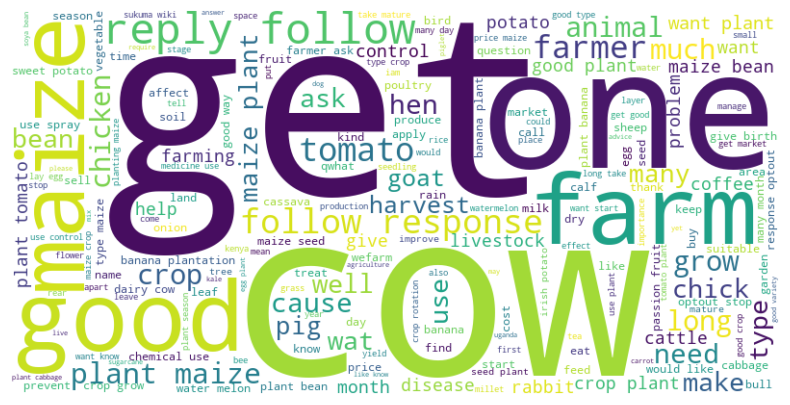

In [23]:
# Filter for 'eng' language only
filtered_sample = sample[sample['question_language'] == 'eng']
filtered_sample['question_content_cleaned'] = filtered_sample['question_content'].apply(process_text)

# Generate word cloud from 'question_content' of filtered data
text = ' '.join(filtered_sample['question_content_cleaned'].dropna().astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=my_stopwords).generate(text)

plt.figure(figsize = (24,5))
plt.title("Word Frequencies", fontsize=24)
plt.xlabel('Words', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
nltk.FreqDist(text.split()).plot(60)
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_222252\3086785645.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



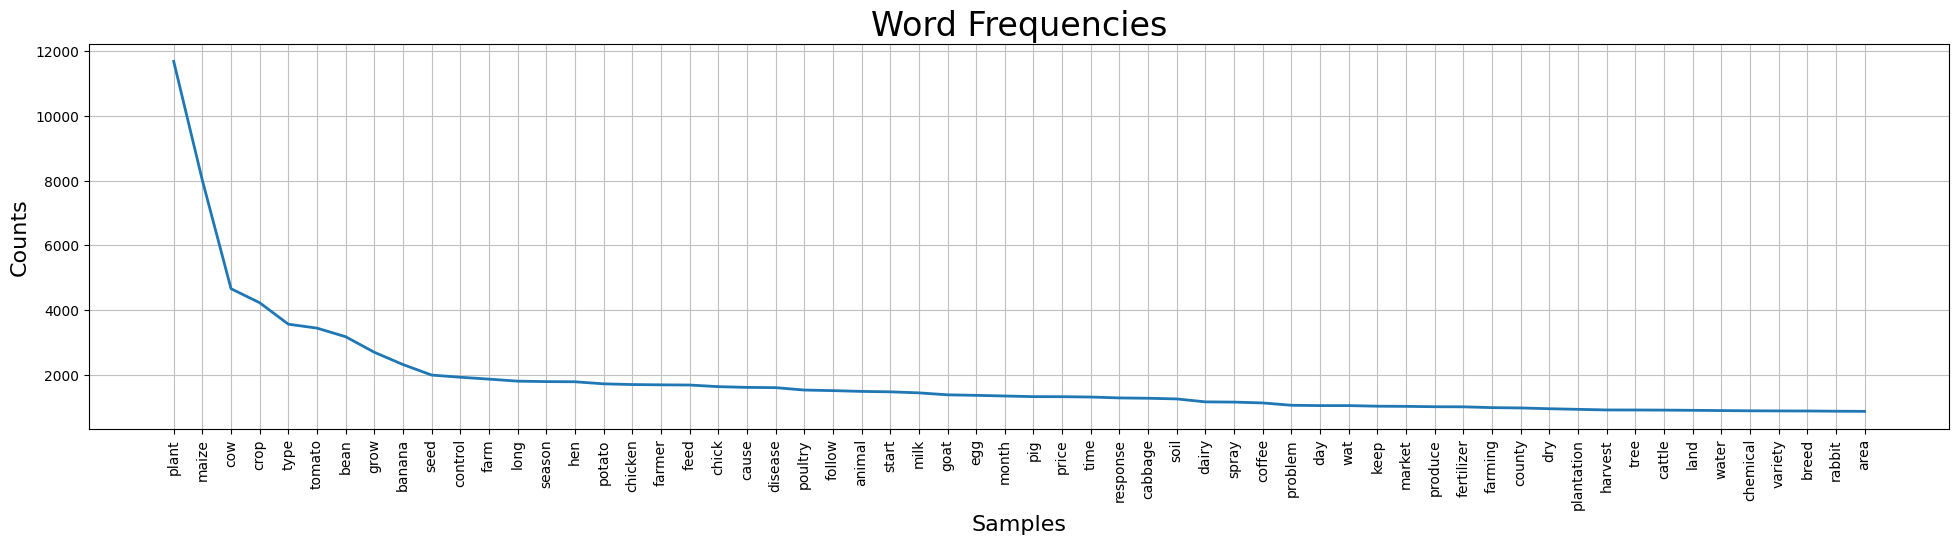

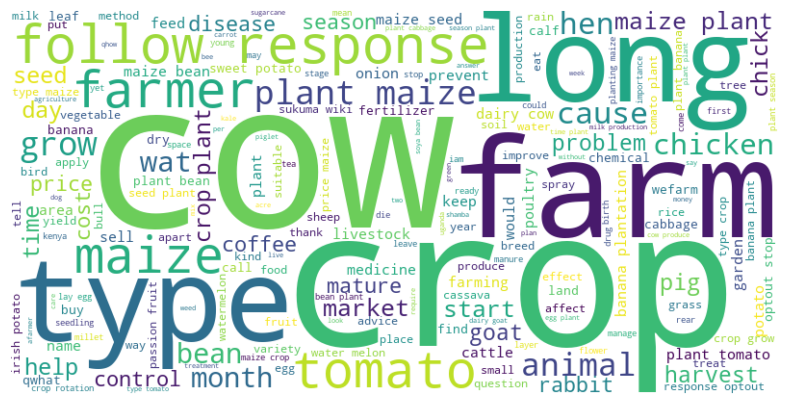

In [24]:
my_stopwords += ['also', 'add', 'get', 'need', 'make', 'take', 'use', 'please', 'perfect', 'fit', 'like', 'bring',
                 'else', 'well', 'one', 'much', 'many', 'thing', 'things', 'lot', 'lots', 'bit', 'ask', 'give',
                 'want', 'good', 'reply', 'know']
# Iterate through columns and apply text cleaning
filtered_sample['question_content_cleaned'] = filtered_sample['question_content'].apply(process_text)

# Generate word cloud from 'question_content' of filtered data
text = ' '.join(filtered_sample['question_content_cleaned'].dropna().astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=my_stopwords).generate(text)

plt.figure(figsize = (24,5))
plt.title("Word Frequencies", fontsize=24)
plt.xlabel('Words', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
nltk.FreqDist(text.split()).plot(60)
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()


STEP: Key Words by Country
['ke' 'ug' 'gb']
['gb', 'ke', 'ug']

Top 20 words for country 'gb' (4 records):
  chili(1), parasite(1), treat(1), rain(1), tomorrow(1), plant(1), tomato(1), inside(1), flat(1), winter(1), cure(1), zombie(1), chicken(1)


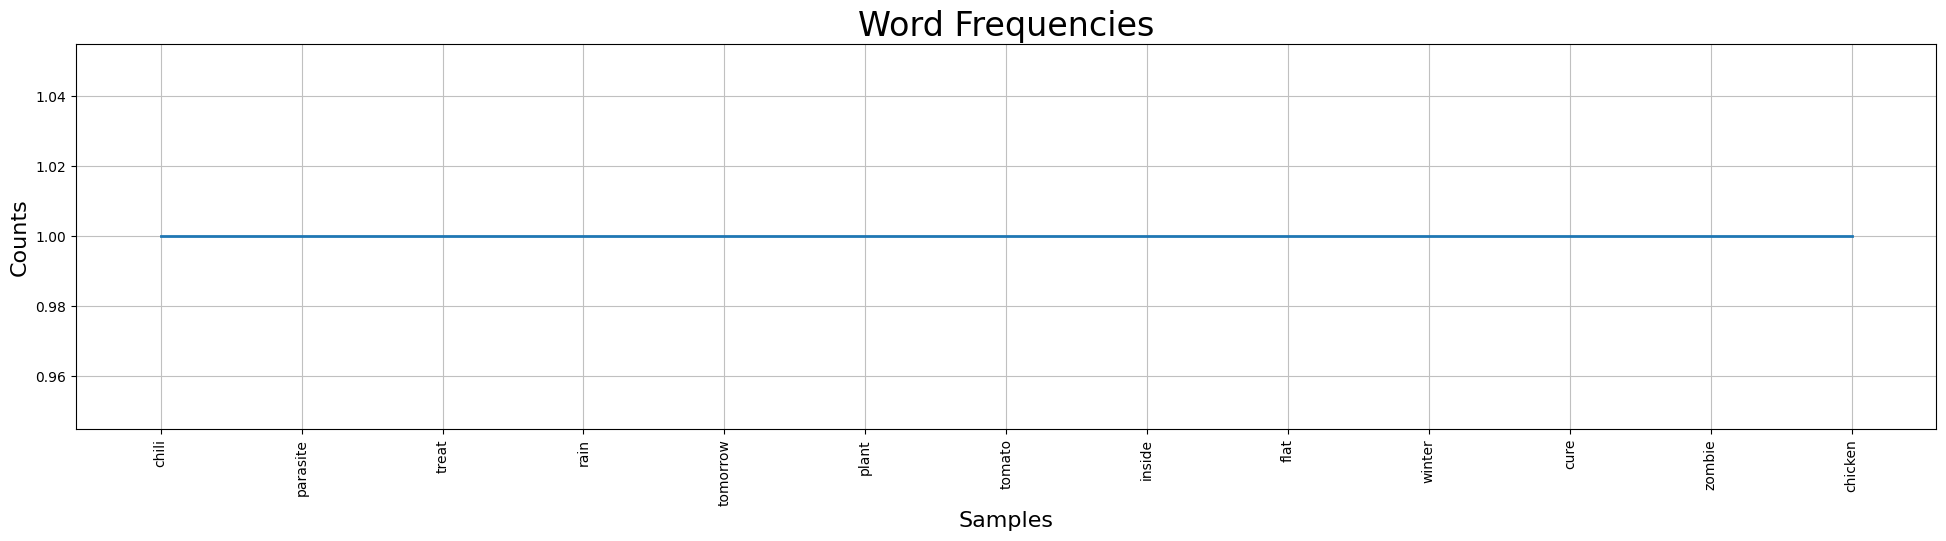

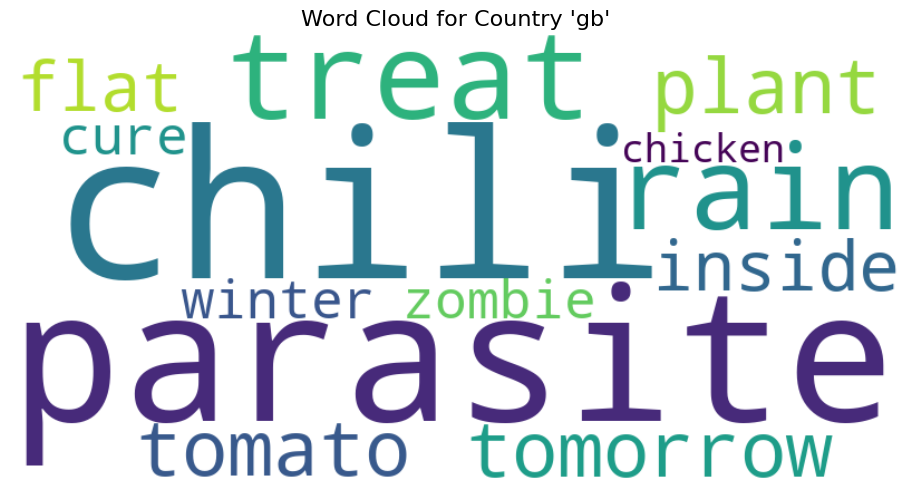


Top 20 words for country 'ke' (36943 records):
  plant(7719), maize(5652), cow(3904), crop(2639), type(2263), tomato(2074), bean(1895), chicken(1422), seed(1404), potato(1376), farm(1343), chick(1330), feed(1262), grow(1207), milk(1203), control(1151), hen(1151), long(1133), dairy(1112), season(1101)


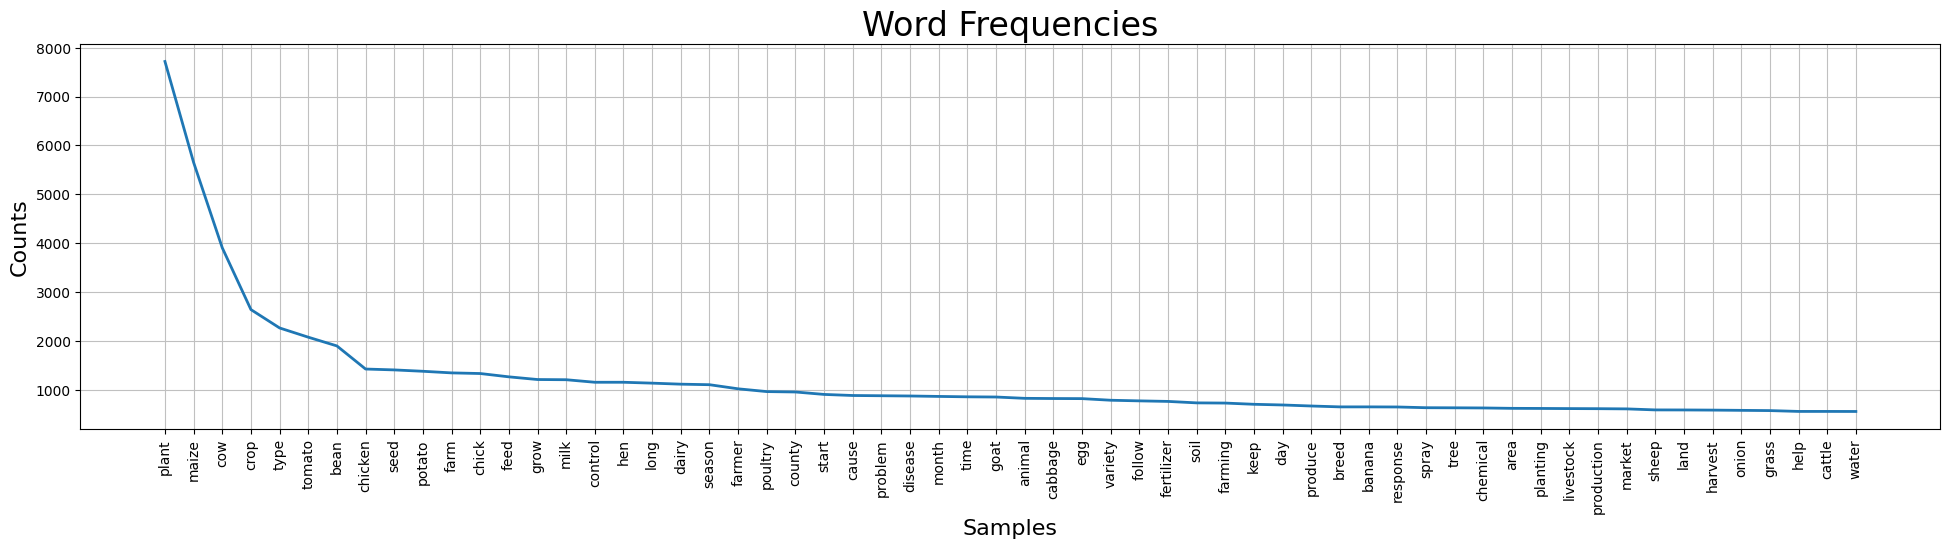

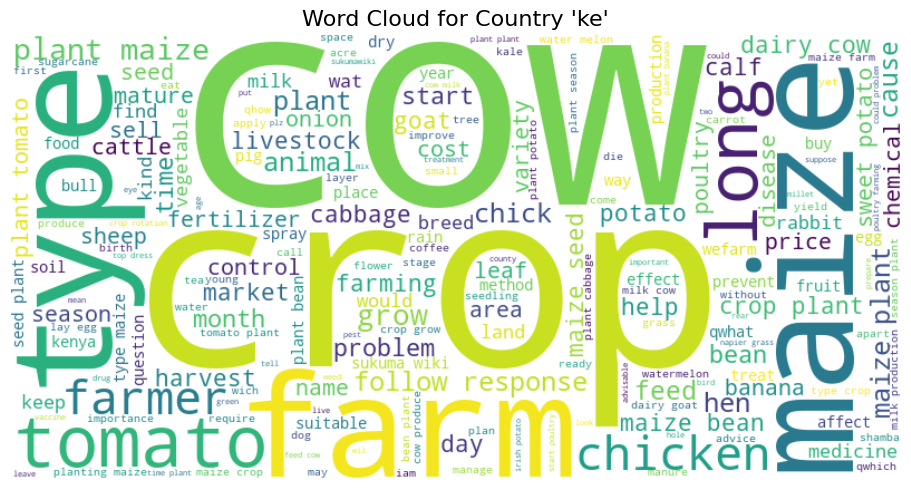


Top 20 words for country 'ug' (21869 records):
  plant(3970), maize(2359), banana(1665), crop(1584), grow(1485), tomato(1363), type(1297), bean(1277), pig(999), price(895), coffee(868), control(768), cow(754), follow(735), disease(727), cause(725), plantation(695), wat(686), season(683), farmer(667)


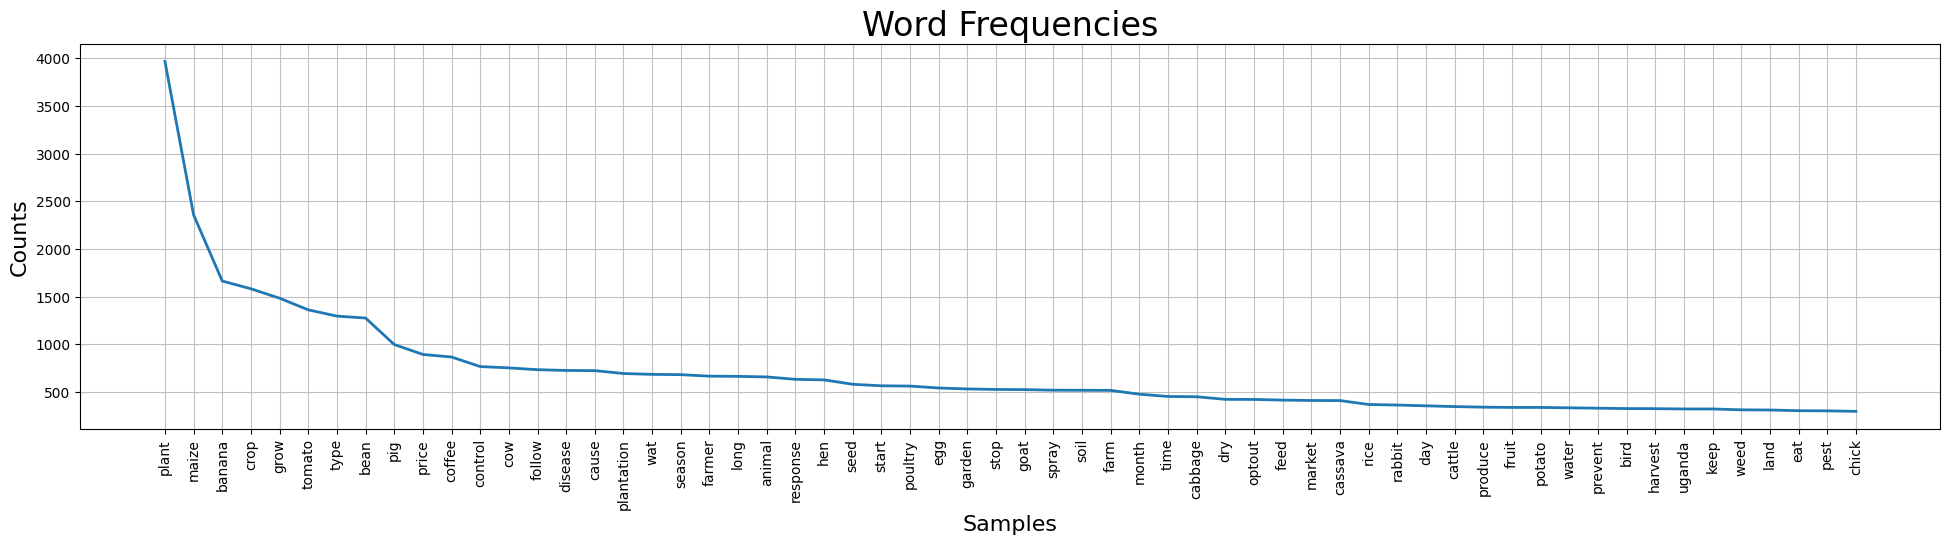

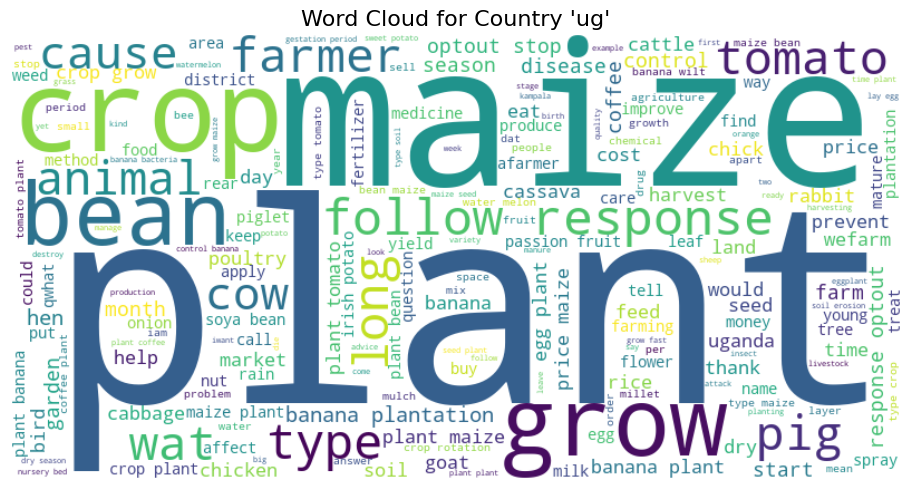

In [25]:
# ============================================================
# Display key words by country
# ============================================================
print("\n" + "=" * 60)
print("STEP: Key Words by Country")
print("=" * 60)

# Get unique countries
countries = filtered_sample['question_user_country_code'].dropna().unique()
print(countries)
print(sorted(countries))

for country in sorted(countries):
    country_sample = filtered_sample[filtered_sample['question_user_country_code'] == country]
    
    if len(country_sample) == 0:
        continue
    
    # Generate text for this country
    country_text = ' '.join(country_sample['question_content_cleaned'].dropna().astype(str).values)
    
    if not country_text.strip():
        print(f"\nNo cleaned text for country: {country}")
        continue
    
    # Get top 20 words for this country
    freq_dist = nltk.FreqDist(country_text.split())
    top_words = freq_dist.most_common(20)
    
    print(f"\nTop 20 words for country '{country}' ({len(country_sample)} records):")
    print(f"  {', '.join([f'{word}({count})' for word, count in top_words])}")
    
    # Generate word cloud for this country
    try:
        wordcloud_country = WordCloud(width=800, height=400, background_color='white', 
                                      stopwords=my_stopwords).generate(country_text)
        
        plt.figure(figsize = (24,5))
        plt.title("Word Frequencies", fontsize=24)
        plt.xlabel('Words', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        nltk.FreqDist(country_text.split()).plot(60)
        plt.show()
        
        plt.figure(figsize=(12, 5))
        plt.imshow(wordcloud_country, interpolation='bilinear')
        plt.title(f"Word Cloud for Country '{country}'", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"  Failed to generate word cloud for {country}: {e}")

## Key Observations

- **question_user_gender** & **response_user_gender**: Severely incomplete (mostly null). Limited predictive value due to sparse coverage; recommend excluding or imputing with caution.
- **response_user_type**: Zero variance (constant value: 'Farmer'). No discriminative power; safe to drop.
- **question_user_type**: Single value observed; dropping if consistent across full dataset.
- **question_user_id** & **response_user_id**: High cardinality (77k+ unique); use as identifiers only, not features.

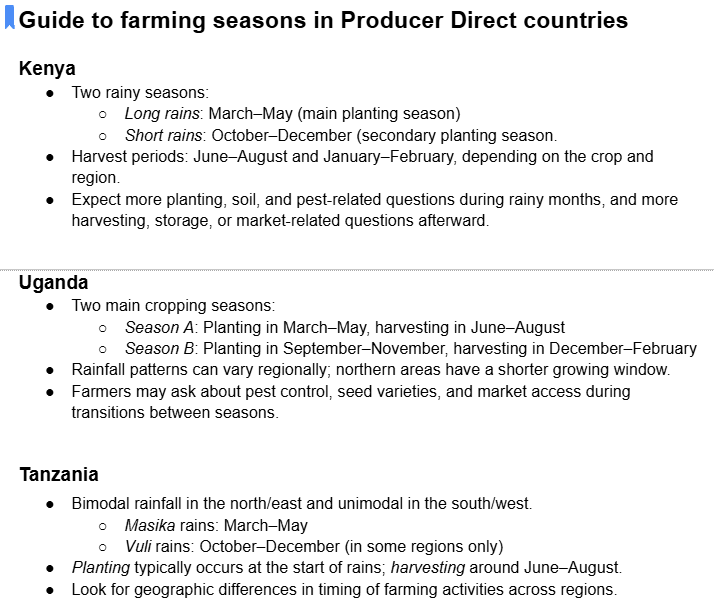

In [27]:
sample["question_sent"] = pd.to_datetime(sample["question_sent"], errors="coerce")

# -------------------------------------------------
# Season classification function
# -------------------------------------------------
def assign_farming_season(row):
    country = str(row["question_user_country_code"]).lower()
    date = row["question_sent"]

    if pd.isna(date) or pd.isna(country):
        return "Not Classified"

    month = date.month

    # ---------------- KENYA ----------------
    if country == "ke":
        if month in [3, 4, 5]:
            return "Long Rains - Planting"
        elif month in [10, 11, 12]:
            return "Short Rains - Planting"
        elif month in [6, 7, 8, 1, 2]:
            return "Harvest Period"
        else:
            return "September - Off-season"

    # ---------------- UGANDA ----------------
    elif country == "ug":
        if month in [3, 4, 5]:
            return "Season A - Planting"
        elif month in [6, 7, 8]:
            return "Season A - Harvest"
        elif month in [9, 10, 11]:
            return "Season B - Planting"
        elif month in [12, 1, 2]:
            return "Season B - Harvest"

    # ---------------- TANZANIA ----------------
    elif country == "tz":
        if month in [3, 4, 5]:
            return "Masika - Planting"
        elif month in [10, 11, 12]:
            return "Vuli - Planting"
        elif month in [6, 7, 8]:
            return "Harvest Period"
        else:
            return "Off-season / Other"

    # ---------------- OTHER ----------------
    else:
        return "Not Classified"

# Apply classifier
sample["farming_season"] = sample.apply(assign_farming_season, axis=1)

# -------------------------------------------------
# Preview result
# -------------------------------------------------
print("\n" + "=" * 60)
print("STEP 3: Preview With Farming Season")
print("=" * 60)

preview_df = sample[
    [
        "question_user_country_code",
        "question_sent",
        "farming_season",
        "question_content",
        "response_content"
    ]
].head(5)

preview_df



STEP 3: Preview With Farming Season


,question_user_country_code,question_sent,farming_season,question_content,response_content
0,ke,2018-08-17 11:09:47.591874+01:00,Harvest Period,Q. Last year i used Ransom to prevent powdery ...,"Q176.paul,hello.Try Rindomil gold.if it persis..."
1,tz,2020-08-14 10:31:47.937520+01:00,Harvest Period,S Kwakawaida kuku huwa anaatamia siku ngapi nd...,S41 Cku 21
2,ug,2019-01-20 16:45:00.640571+00:00,Season B - Harvest,E Canter ya watermelon negura eta okwo?,E31 \n3 000 mijina Rwemikoma
3,ug,2020-05-02 19:46:01.502960+01:00,Season A - Planting,Q Am Denis From Kaliro What Requrement If I Ne...,"Q202.YOU HAVE TO GET ,MUKENE MAIZEGRADE,"
4,ke,2020-12-27 05:10:16.805963+00:00,Short Rains - Planting,What is the name of the good food for the ...,Q 111 Chick mash.
